# Predicting Congenital Disorder using Ensemble Learning
https://www.kaggle.com/c/ga-dat-syd13/data

Author: <div class="LI-profile-badge"  data-version="v1" data-size="medium" data-locale="en_US" data-type="horizontal" data-theme="dark" data-vanity="aroraaman"><a class="LI-simple-link" href='https://au.linkedin.com/in/aroraaman?trk=profile-badge'>Aman Arora</a></div>  

**So, What is a congenital disorder?** <br> 
Most babies are born healthy, but when a baby has a condition that is present from birth, it is called a congenital disorder. Congenital disorders can be inherited or caused by environmental factors and their impact on a child’s health and development can vary from mild to severe. A child with a congenital disorder may experience a disability or health problems throughout life. (https://www.pregnancybirthbaby.org.au/what-is-a-congenital-disorder)

**Here are some of the resources that I referenced before creating this notebook:**<br>
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
2. General Assembly, Sydney - Linear Regression iPython Notebook -
Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City); <br>
Taught by: **Dima Galat** (https://www.linkedin.com/in/dimagalat/)
5. https://www.booktopia.com.au/multivariate-data-analysis-joe-f-hair/prod9781292021904.html?source=pla&gclid=EAIaIQobChMIpJ2qkJLO3QIV16mWCh3RBAFUEAQYASABEgL39vD_BwE (MultiVariate Data Analysis)
6. https://www-bcf.usc.edu/~gareth/ISL/ Introduction to Statistical Learning (James et al., 2014)
7. https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
8. https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
9. https://www.kaggle.com/apapiu/regularized-linear-models

### Importing Libraries

In [1]:
#Getting the toolkit together
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.preprocessing import StandardScaler
plt.style.use("fivethirtyeight")
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,\
                            roc_curve,roc_auc_score,classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import statsmodels.api as sm

### Data EDA

I performed initial EDA for this data set in my notebook 'Predicting Congenital Disorder using Resampling.ipynb'. Therefore, here I will just clean my data - remove nulls and implement Support Vector Machine model.

In [2]:
#importing data
train_path = '/Users/user/Desktop/Folders/Data_Scientist/Project 3_ GA/health-diagnostics-train.csv'
health_df =pd.read_csv(train_path)

# importing data
test_path = '/Users/user/Desktop/Folders/Data_Scientist/Project 3_ GA/health-diagnostics-test.csv'
health_df_test =pd.read_csv(test_path)

In [3]:
health_df.replace('#NULL!', np.NaN, inplace = True)
health_df_test.replace('#NULL!', np.NaN, inplace = True)

In [4]:
for col in health_df.columns[:-1]:
    health_df[col] = health_df[col].astype(float, errors = 'raise')
    
for col in health_df_test.columns:
    health_df_test[col] = health_df_test[col].astype(float, errors = 'raise')

I have tried different combinations of imputing data and dropping data already while working on this exercise. It makes sense to impute the mode() in missing values as these are categorical features. However, imputing in test with mode() and dropping train values gives maximum accuracy. <br>
Why? Well, first of all we have over 30,000 values in train data. Losing 900 is approx 3% of the data. This data is not unique and exists for target == 0, that is, our majority class. We are not missing the minority class, therefore, it is safe to drop this data in Train. For our test data, we cannot drop any data and therefore, we will be imputing with mode(). 

In [5]:
# health_df.dropna(inplace = True)
health_df = health_df.apply(lambda x: x.fillna(x.median()),axis=0)
health_df_test['Target'].fillna(0,inplace = True)
health_df_test = health_df_test.apply(lambda x: x.fillna(x.median()),axis=0)

In [6]:
# NEW QUERY 
health_df = health_df.dropna()
health_df.shape

(32670, 10)

**TRAIN TEST SPLIT**

In [7]:
X = health_df.loc[:, health_df.columns != 'target']
y = health_df['target']

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify = y, random_state = 123)

In [9]:
X_train.shape

(26136, 9)

In [10]:
X_test.shape

(6534, 9)

### Implementing Ensemble Learning

After having tried different Ensemble Learning, I found a combination of Random Forest and Logistic Regression to perform best on our test data. (Cross Validation)

**Logistic Regression**

In [11]:
result = sm.Logit(y_train, X_train).fit()

print (result.summary())

Optimization terminated successfully.
         Current function value: 0.012339
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                26136
Model:                          Logit   Df Residuals:                    26127
Method:                           MLE   Df Model:                            8
Date:                Tue, 23 Oct 2018   Pseudo R-squ.:                 0.06264
Time:                        22:09:11   Log-Likelihood:                -322.49
converged:                       True   LL-Null:                       -344.04
                                        LLR p-value:                 8.407e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
income              -1.2579      0.115    -10.920      0.000      -1.484      -1.032
maternal  

In [12]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 


y_pred = result.predict(X_test)
threshold = Find_Optimal_Cutoff(y_test, y_pred)
print(threshold)

y_pred_class = np.where(y_pred >= threshold, 1, 0) 

cnf_matrix = confusion_matrix(y_test, y_pred_class)
TP = cnf_matrix[1,1,]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
ACC = (TP+TN)/(TP+TN+FP+FN)
wtACC = (0.7*TPR) + (0.3*TNR)
prec = TP/(TP+FP)
G_mean = np.sqrt(TPR * TNR)
print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN) 
print("AUC: {}".format(roc_auc_score(y_test, y_pred_class)))
print('PRECISION:',prec)
print('TPR:',TPR)
print('TNR:',TNR)
print('ACC:',ACC)
print('wtACC:',wtACC)
print('G_mean:',G_mean)
print('-'*100)

final_logreg = y_pred_class

[0.0014196990850280026]
the recall for this model is : 0.75
TP 9
TN 5067
FP 1455
FN 3
AUC: 0.7634544618215272
PRECISION: 0.006147540983606557
TPR: 0.75
TNR: 0.7769089236430543
ACC: 0.7768595041322314
wtACC: 0.7580726770929163
G_mean: 0.7633358977097112
----------------------------------------------------------------------------------------------------


**Weighted Random Forest**

In [13]:
target_count = pd.Series(y_train).value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion of majority to minority class:', round(target_count[0] / target_count[1], 2), ': 1')

prop = round(target_count[0] / target_count[1],2)

Class 0: 26089
Class 1: 47
Proportion of majority to minority class: 555.09 : 1


In [14]:
RF = RandomForestClassifier(n_estimators = 100,
                            class_weight={0: 1/prop,1:2.0},
                            max_features = 1,
                            min_samples_leaf = 70,
                            criterion = 'gini',
                            random_state = 60,
                            bootstrap = True,
                            warm_start = False
                           )
RF.fit(X_train,y_train)

y_pred = RF.predict(X_test)

#Evaluation
cnf_matrix=confusion_matrix(y_test,y_pred)
TP = cnf_matrix[1,1,]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
ACC = (TP+TN)/(TP+TN+FP+FN)
wtACC = (0.7*TPR) + (0.3*TNR)
prec = TP/(TP+FP)
G_mean = np.sqrt(TPR * TNR)
print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN) 
print("AUC: {}".format(roc_auc_score(y_test, y_pred_class)))
print('PRECISION:',prec)
print('TPR:',TPR)
print('TNR:',TNR)
print('ACC:',ACC)
print('wtACC:',wtACC)
print('G_mean:',G_mean)
print('-'*100)
 
final_rf = y_pred

the recall for this model is : 0.75
TP 9
TN 5872
FP 650
FN 3
AUC: 0.7634544618215272
PRECISION: 0.013657056145675266
TPR: 0.75
TNR: 0.9003373198405397
ACC: 0.9000612182430364
wtACC: 0.7951011959521618
G_mean: 0.8217377865720943
----------------------------------------------------------------------------------------------------


the recall for this model is: 0.75
TP 9
TN 6242
FP 280
FN 3
AUC: 0.8535341919656547
PRECISION: 0.031141868512110725
TPR: 0.75
TNR: 0.9570683839313094
ACC: 0.9566880930517294
wtACC: 0.8121205151793927
G_mean: 0.8472315432917273
----------------------------------------------------------------------------------------------------


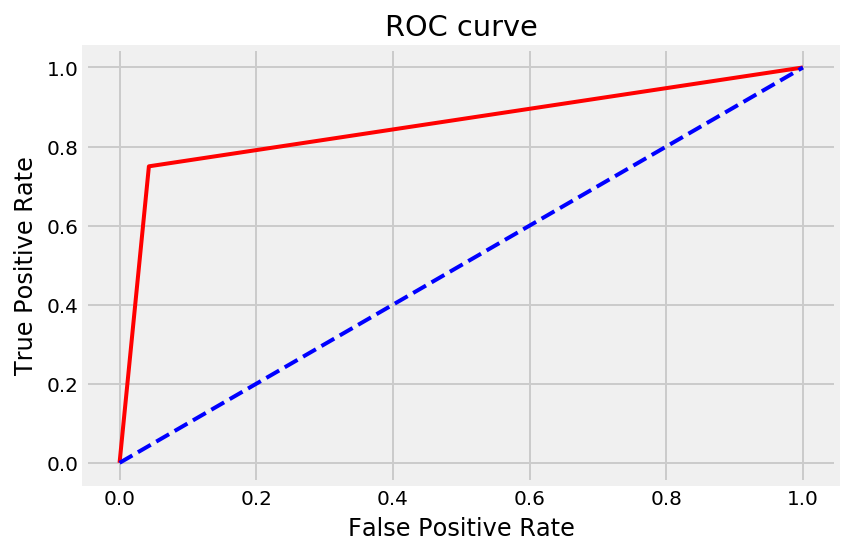

In [15]:
final = np.logical_and(pd.Series(final_logreg),pd.Series(final_rf))

y_pred_class = final
cnf_matrix=confusion_matrix(y_test,y_pred_class)
TP = cnf_matrix[1,1,]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
ACC = (TP+TN)/(TP+TN+FP+FN)
wtACC = (0.7*TPR) + (0.3*TNR)
prec = TP/(TP+FP)
G_mean = np.sqrt(TPR * TNR)
print("the recall for this model is:",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN) 
print("AUC: {}".format(roc_auc_score(y_test, y_pred_class)))
print('PRECISION:',prec)
print('TPR:',TPR)
print('TNR:',TNR)
print('ACC:',ACC)
print('wtACC:',wtACC)
print('G_mean:',G_mean)
print('-'*100)

fpr, tpr, threshold = roc_curve(y_test, y_pred_class)
auc_score = roc_auc_score(y_test, y_pred_class)
plt.figure()
plt.plot(fpr, tpr, color='red',
lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Therefore, an ensemble performs the best with an AUC score of 0.85, a TPR of 0.75, TNR of 0.95 and weighted Accuracy of 0.81.